In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations


import string
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [50]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [51]:
feedback_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [52]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

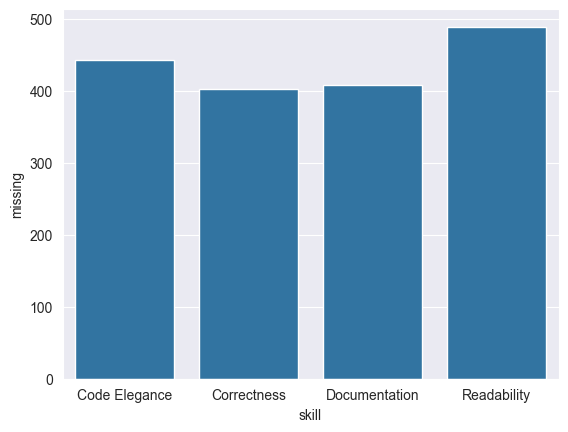

In [53]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### All unique feedback

In [54]:
unique_feedback_df = feedback_df[['skill', 'comments']]
unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()
unique_feedback_df = unique_feedback_df.groupby('skill').value_counts().reset_index()
unique_feedback_df.to_csv('data/unique_feedback.csv', index=False)
unique_feedback_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_18272/389625499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()


,skill,comments,count
0,Code Elegance,"effective use of object-oriented principles, e...",38
1,Code Elegance,"methods are reusable and readable, but some co...",13
2,Code Elegance,the design could have been better.,13
3,Code Elegance,"it is good, though there are little problems h...",11
4,Code Elegance,solid implementation of both core and challeng...,11
...,...,...,...
1844,Readability,"very well written, code is simple and well mai...",1
1845,Readability,well structure and easy to read,1
1846,Readability,"well structured, code is easy to read",1
1847,Readability,with clear variable names and straightforward ...,1


https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

### NLP Techniques

In [55]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [56]:
stopwords = nltk.corpus.stopwords.words('english')

def process_comments(comments):
    comments = comments.lower()
    comments = comments.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    tokens = nltk.word_tokenize(comments)
    
    tokens = [w for w in tokens if w not in stopwords]

    return tokens

In [57]:
nlp_df['tokens'] = nlp_df['comments'].apply(process_comments)
nlp_df['bigrams'] = nlp_df['tokens'].apply(lambda l: list(nltk.bigrams(l)))
nlp_df['trigrams'] = nlp_df['tokens'].apply(lambda l: list(nltk.ngrams(l, 3)))
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,bigrams,trigrams
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...","[(code, use), (use, meaningful), (meaningful, ...","[(code, use, meaningful), (use, meaningful, id..."
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, lo..."
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, co..."
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re..."
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re..."
...,...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...","[(implementation, good), (good, distinguishabl...","[(implementation, good, distinguishable), (goo..."
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]","[(compiling, specific), (specific, musicplayer...","[(compiling, specific, musicplayer), (specific..."
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...","[(comments, redundant), (redundant, state), (s...","[(comments, redundant, state), (redundant, sta..."
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...","[(methods, lack), (lack, detailed), (detailed,...","[(methods, lack, detailed), (lack, detailed, c..."


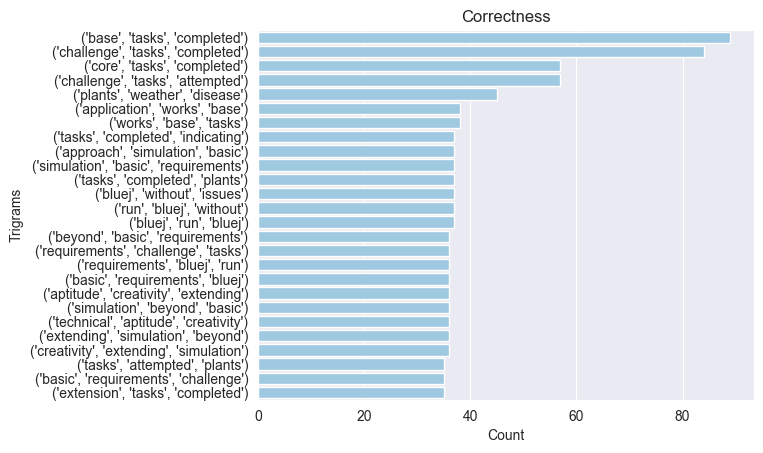

In [58]:
expl_df = nlp_df[nlp_df['skill'] == 'Correctness']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 35], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams', title='Correctness')
g.get_figure().savefig('plots/correctness_trigrams.pdf', bbox_inches='tight')

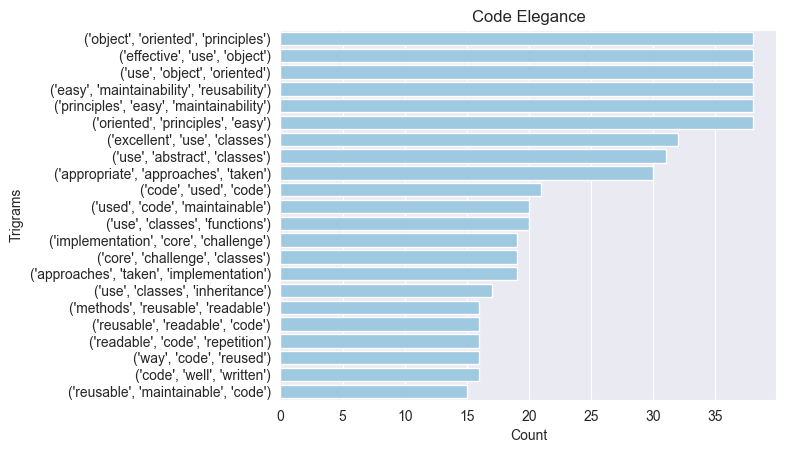

In [59]:
expl_df = nlp_df[nlp_df['skill'] == 'Code Elegance']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 15], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams', title='Code Elegance')
g.get_figure().savefig('plots/code_elegance_trigrams.pdf', bbox_inches='tight')

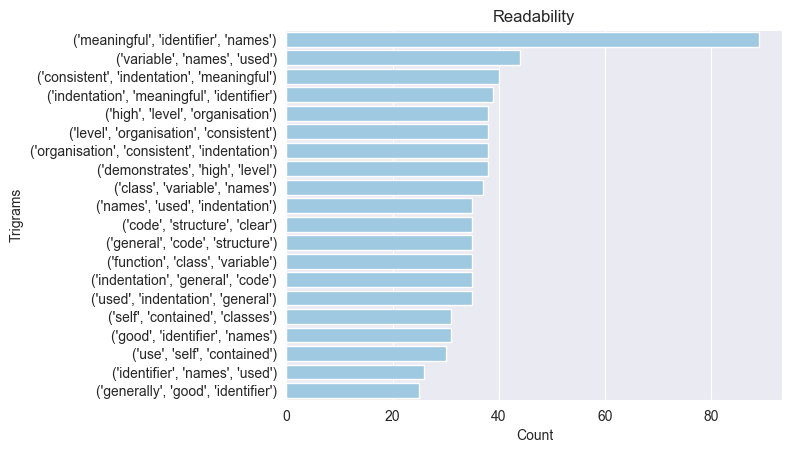

In [60]:
expl_df = nlp_df[nlp_df['skill'] == 'Readability']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 25], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams', title='Readability')
g.get_figure().savefig('plots/readability_trigrams.pdf', bbox_inches='tight')

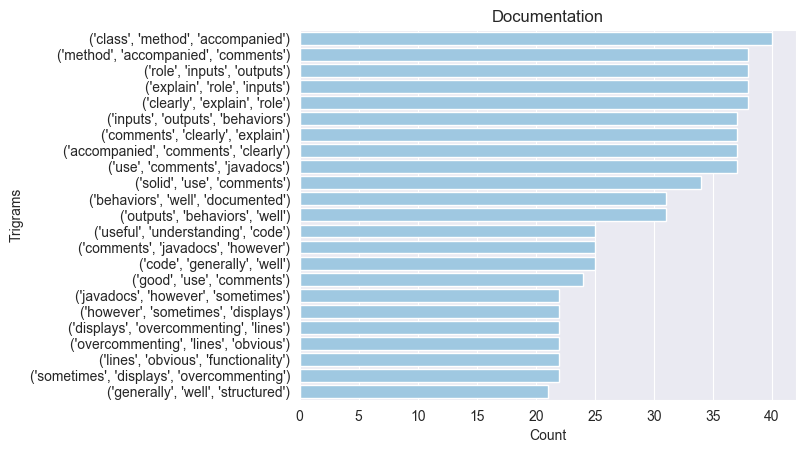

In [61]:
expl_df = nlp_df[nlp_df['skill'] == 'Documentation']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 20], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams', title='Documentation')
g.get_figure().savefig('plots/documentation_trigrams.pdf', bbox_inches='tight')

### Sentiment

In [62]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,bigrams,trigrams,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...","[(code, use), (use, meaningful), (meaningful, ...","[(code, use, meaningful), (use, meaningful, id...",True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, lo...",True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, co...",True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True
...,...,...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...","[(implementation, good), (good, distinguishabl...","[(implementation, good, distinguishable), (goo...",False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]","[(compiling, specific), (specific, musicplayer...","[(compiling, specific, musicplayer), (specific...",False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...","[(comments, redundant), (redundant, state), (s...","[(comments, redundant, state), (redundant, sta...",True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...","[(methods, lack), (lack, detailed), (detailed,...","[(methods, lack, detailed), (lack, detailed, c...",True


In [63]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


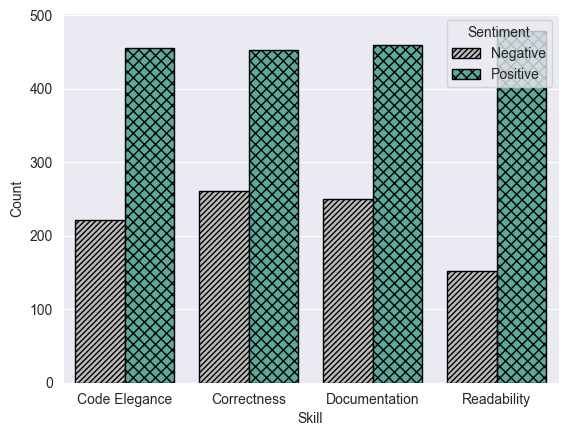

In [64]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('plots/sentiment.pdf', bbox_inches='tight')

# Consistency
## Individual graders

In [65]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [66]:
intra_rater_df = feedback_df[feedback_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'comments']]
intra_rater_df.to_csv('data/intra_rater.csv', index=False)
intra_rater_df

,assignment_number,skill,participant_id,batch,comments
12,358.0,Readability,15,1,The code is generally clean and organized with...
12,358.0,Correctness,15,1,All of the base tasks are completed - the simu...
12,358.0,Code Elegance,15,1,The code demonstrates good use of classes and ...
12,358.0,Documentation,15,1,"Most classes and functions have clear, useful ..."
0,160.0,Readability,24,1,The student used indentation appropriately and...
...,...,...,...,...,...
19,144.0,Documentation,1,1,Code is documented well.
12,358.0,Readability,14,1,there are a few instances where naming consist...
12,358.0,Correctness,14,1,NaN
12,358.0,Code Elegance,14,1,NaN



### Length of comments

In [67]:
intra_rater_df['length'] = intra_rater_df['comments'].str.len()
intra_rater_df['length'] = intra_rater_df['length'].fillna(0)
intra_rater_df

,assignment_number,skill,participant_id,batch,comments,length
12,358.0,Readability,15,1,The code is generally clean and organized with...,129.0
12,358.0,Correctness,15,1,All of the base tasks are completed - the simu...,533.0
12,358.0,Code Elegance,15,1,The code demonstrates good use of classes and ...,231.0
12,358.0,Documentation,15,1,"Most classes and functions have clear, useful ...",150.0
0,160.0,Readability,24,1,The student used indentation appropriately and...,84.0
...,...,...,...,...,...,...
19,144.0,Documentation,1,1,Code is documented well.,24.0
12,358.0,Readability,14,1,there are a few instances where naming consist...,88.0
12,358.0,Correctness,14,1,NaN,0.0
12,358.0,Code Elegance,14,1,NaN,0.0


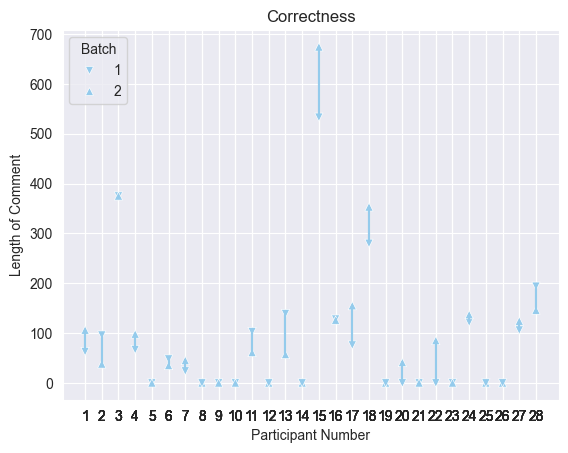

In [68]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Correctness')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch', loc='upper left')
dist_plt.get_figure().savefig('plots/feedback_correctness_distance.pdf', bbox_inches='tight')

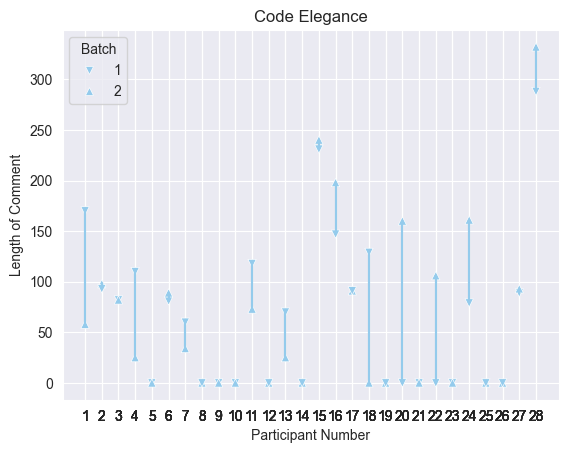

In [69]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/feedback_code_elegance_distance.pdf', bbox_inches='tight')

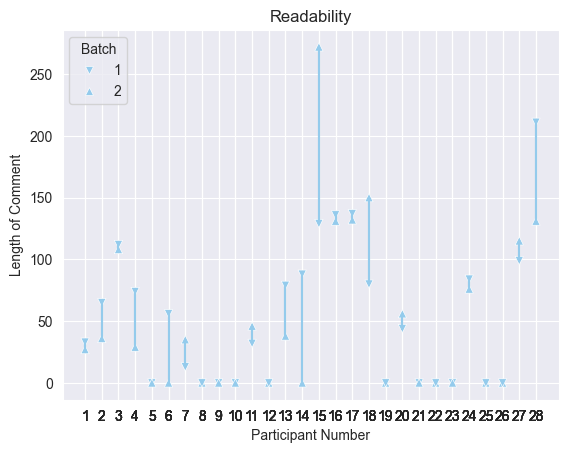

In [70]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Readability')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch', loc='upper left')
dist_plt.get_figure().savefig('plots/feedback_readability_distance.pdf', bbox_inches='tight')

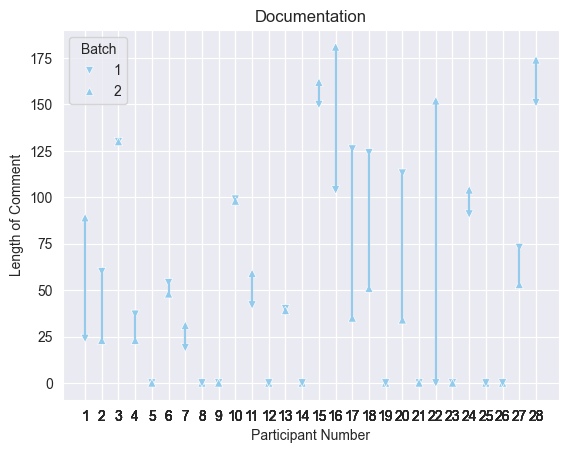

In [71]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Documentation')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/feedback_documentation_distance.pdf', bbox_inches='tight')

### Comment Similarity

In [72]:
sim_df = pd.read_csv('data/similarity_analysis_output.csv')
sim_df

,assignment_number,skill,participant_id,feedback_1,feedback_2,sim
0,97.0,Code Elegance,11,Good usage of organism abstract class. animals...,"good abstraction level, code is not rewritten ...",0.475714
1,97.0,Correctness,11,unclear what the natural disasters do; they ju...,core and challenging tasks completed. added na...,0.522516
2,97.0,Documentation,10,This submission is completely identical to the...,This submission is completely identical to the...,0.899581
3,97.0,Documentation,11,documented well. every function is defined,documentation is clear and defines every class...,0.743613
4,97.0,Readability,11,code is clean and simple to read,code is clear and follows consistent structure,0.662336
...,...,...,...,...,...,...
64,559.0,Correctness,7,It is basically correct.,Some efforts have been put into this project.,0.078713
65,559.0,Documentation,6,Missing return and parameter comments for some...,Missing param comment in method header comments,0.660806
66,559.0,Documentation,7,Better than others.,"It is good, though not perfect.",0.454978
67,559.0,Readability,6,"Good variable naming, public used where could ...",No comment supplied,0.068642


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_18272/218282335.py:19: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.swarmplot(x="participant_id", y="sim", hue="skill", data=sim_df, size=6, ax=ax, dodge=True, palette=color_pallete)


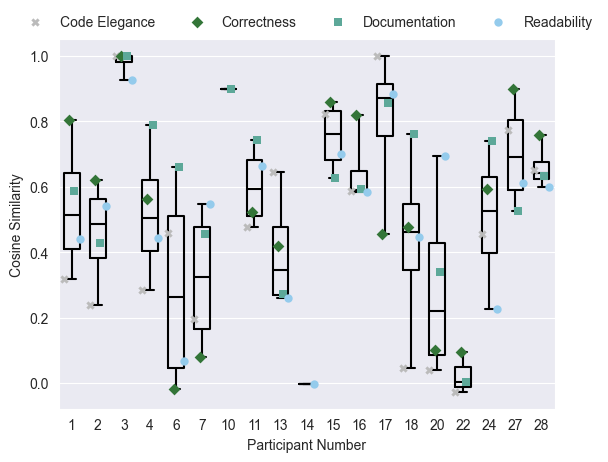

In [73]:
# Plot swarm plot with different markers: https://stackoverflow.com/questions/52878845/swarmplot-with-hue-affecting-marker-beyond-color
fig, ax = plt.subplots(1,1)
# dummy plots, just to get the Path objects
correctness = ax.scatter([1,2],[3,4], marker='X')
readability = ax.scatter([1,2],[3,4], marker='D')
documentation = ax.scatter([1,2],[3,4], marker='s')
code_elegance = ax.scatter([1,2],[3,4], marker='o')

correctness_mk, = correctness.get_paths()
readability_mk, = readability.get_paths()
documentation_mk, = documentation.get_paths()
code_elegance_mk, = code_elegance.get_paths()

correctness.remove()
readability.remove()
documentation.remove()
code_elegance.remove()

ax = sns.swarmplot(x="participant_id", y="sim", hue="skill", data=sim_df, size=6, ax=ax, dodge=True, palette=color_pallete)
N_hues = len(pd.unique(sim_df['skill']))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([correctness_mk])
for a in c[1::N_hues]:
    a.set_paths([readability_mk])
for a in c[2::N_hues]:
    a.set_paths([documentation_mk])
for a in c[3::N_hues]:
    a.set_paths([code_elegance_mk])

sns.boxplot(sim_df, x='participant_id', y='sim', whis=[0, 100], width=.6, fill=False, color='black')

ax.set(xlabel='Participant Number', ylabel='Cosine Similarity')
ax.legend(c[-4:],pd.unique(sim_df['skill']), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

ax.get_figure().savefig('plots/sim.pdf', bbox_inches='tight')

## Multiple Graders

In [113]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

feedback_df['group'] = feedback_df['participant_id'].apply(map_participant_group)
feedback_df['group'] = pd.Categorical(feedback_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df = feedback_df.sort_values('group', ascending=True)
feedback_df.to_csv('data/inter_rater.csv')
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group,length
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4,108
4,188.0,Some method names are misleading,Readability,2,2,B,1-4,32
3,542.0,No comment supplied,Readability,2,2,A-,1-4,19
2,277.0,No comment supplied,Readability,2,2,A-,1-4,19
1,303.0,No comment supplied,Readability,2,2,A-,1-4,19
...,...,...,...,...,...,...,...,...
19,462.0,No java source files were included in the subm...,Correctness,28,2,F,25-28,105
18,454.0,The student has implemented all baseline requi...,Correctness,28,2,A++,25-28,213
17,287.0,The student implemented all baseline requireme...,Correctness,28,2,A,25-28,144
12,510.0,No comment supplied,Code Elegance,26,2,B+,25-28,19


### Length

In [115]:
feedback_df['comments'] = feedback_df['comments'].fillna("No comment supplied")
feedback_df['length'] = feedback_df['comments'].apply(len)
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group,length
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4,108
4,188.0,Some method names are misleading,Readability,2,2,B,1-4,32
3,542.0,No comment supplied,Readability,2,2,A-,1-4,19
2,277.0,No comment supplied,Readability,2,2,A-,1-4,19
1,303.0,No comment supplied,Readability,2,2,A-,1-4,19
...,...,...,...,...,...,...,...,...
19,462.0,No java source files were included in the subm...,Correctness,28,2,F,25-28,105
18,454.0,The student has implemented all baseline requi...,Correctness,28,2,A++,25-28,213
17,287.0,The student implemented all baseline requireme...,Correctness,28,2,A,25-28,144
12,510.0,No comment supplied,Code Elegance,26,2,B+,25-28,19


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_18272/4101221571.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  length_plt = sns.stripplot(feedback_df, x='group', y='length', hue='skill', dodge=True, palette=color_pallete)


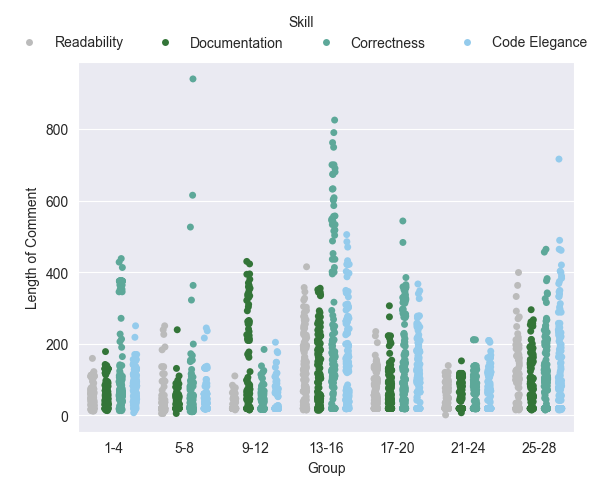

In [116]:
length_plt = sns.stripplot(feedback_df, x='group', y='length', hue='skill', dodge=True, palette=color_pallete)
length_plt.set(xlabel='Group', ylabel='Length of Comment')
# sns.move_legend(length_plt, "upper left", bbox_to_anchor=(1, 1), title='Skill')
sns.move_legend(
    length_plt, "lower center",
    bbox_to_anchor=(.45, 1), ncol=4, title='Skill', frameon=False,
)
length_plt.get_figure().savefig('plots/inter_rater_length.pdf', bbox_inches='tight')

### Comment Similarity
- Same plot as Intra-rater or something with heatmaps maybe a facet grid (skill, group, assignment??)
- Calculate cosine similarity for each pair for each skill, group and assignment
  - Generate n x n similarity matrix
  - Compute the average for the matrix
  - Discuss on Monday?

In [117]:
inter_rater_sim_df = pd.read_csv('data/inter_rater_sim.csv')
inter_rater_sim_df[:100]

,group,skill,assignment_number,participant_id_1,participant_id_2,feedback_1,feedback_2,sim
0,1-4,Readability,302.0,1,2,Good code readability.,No comment supplied,0.147519
1,1-4,Readability,302.0,1,3,Good code readability.,The code demonstrates a high level of organisa...,0.507659
2,1-4,Readability,302.0,1,4,Good code readability.,"Code not very easy to read, names of variables...",0.506794
3,1-4,Readability,302.0,2,3,No comment supplied,The code demonstrates a high level of organisa...,0.065517
4,1-4,Readability,302.0,2,4,No comment supplied,"Code not very easy to read, names of variables...",0.123910
...,...,...,...,...,...,...,...,...
95,1-4,Readability,327.0,3,4,The code demonstrates a high level of organisa...,Very easy to understand and to read,0.284639
96,1-4,Readability,219.0,1,2,Generally good readability.,Some method names are misleading,0.149344
97,1-4,Readability,219.0,1,3,Generally good readability.,The code demonstrates a high level of organisa...,0.309150
98,1-4,Readability,219.0,1,4,Generally good readability.,Easy to read,0.577006


In [136]:
def generate_heatmap_data(skill, group):
    temp_df = inter_rater_sim_df[(inter_rater_sim_df['skill'] == skill) & (inter_rater_sim_df['group'] == group)].sort_values(['participant_id_1', 'participant_id_2'])

    group_bounds = group.split('-')
    
    for i in range(int(group_bounds[0]), int(group_bounds[1])): 
        temp_df.loc[len(temp_df.index)] = [group, skill, np.nan, i, i, np.nan, np.nan, np.nan]
    
    temp_df = temp_df.pivot_table(index='participant_id_1', columns='participant_id_2', values='sim')
    return temp_df

In [137]:
test_df = generate_heatmap_data('Correctness', '1-4')

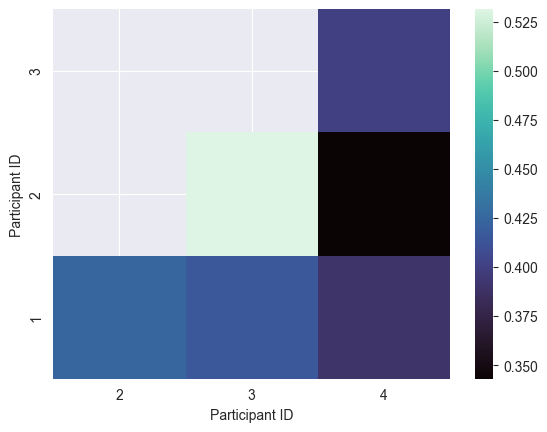

In [166]:

ax = sns.heatmap(test_df, cmap=sns.color_palette("mako", as_cmap=True))
ax.set(xlabel='Participant ID', ylabel='Participant ID')
ax.invert_yaxis()

1-4 Readability
1-4 Documentation
1-4 Correctness
1-4 Code Elegance
5-8 Readability
5-8 Documentation
5-8 Correctness
5-8 Code Elegance
9-12 Readability
9-12 Documentation
9-12 Correctness
9-12 Code Elegance
13-16 Readability
13-16 Documentation
13-16 Correctness
13-16 Code Elegance
17-20 Readability
17-20 Documentation
17-20 Correctness
17-20 Code Elegance
21-24 Readability
21-24 Documentation
21-24 Correctness
21-24 Code Elegance
25-28 Readability
25-28 Documentation
25-28 Correctness
25-28 Code Elegance


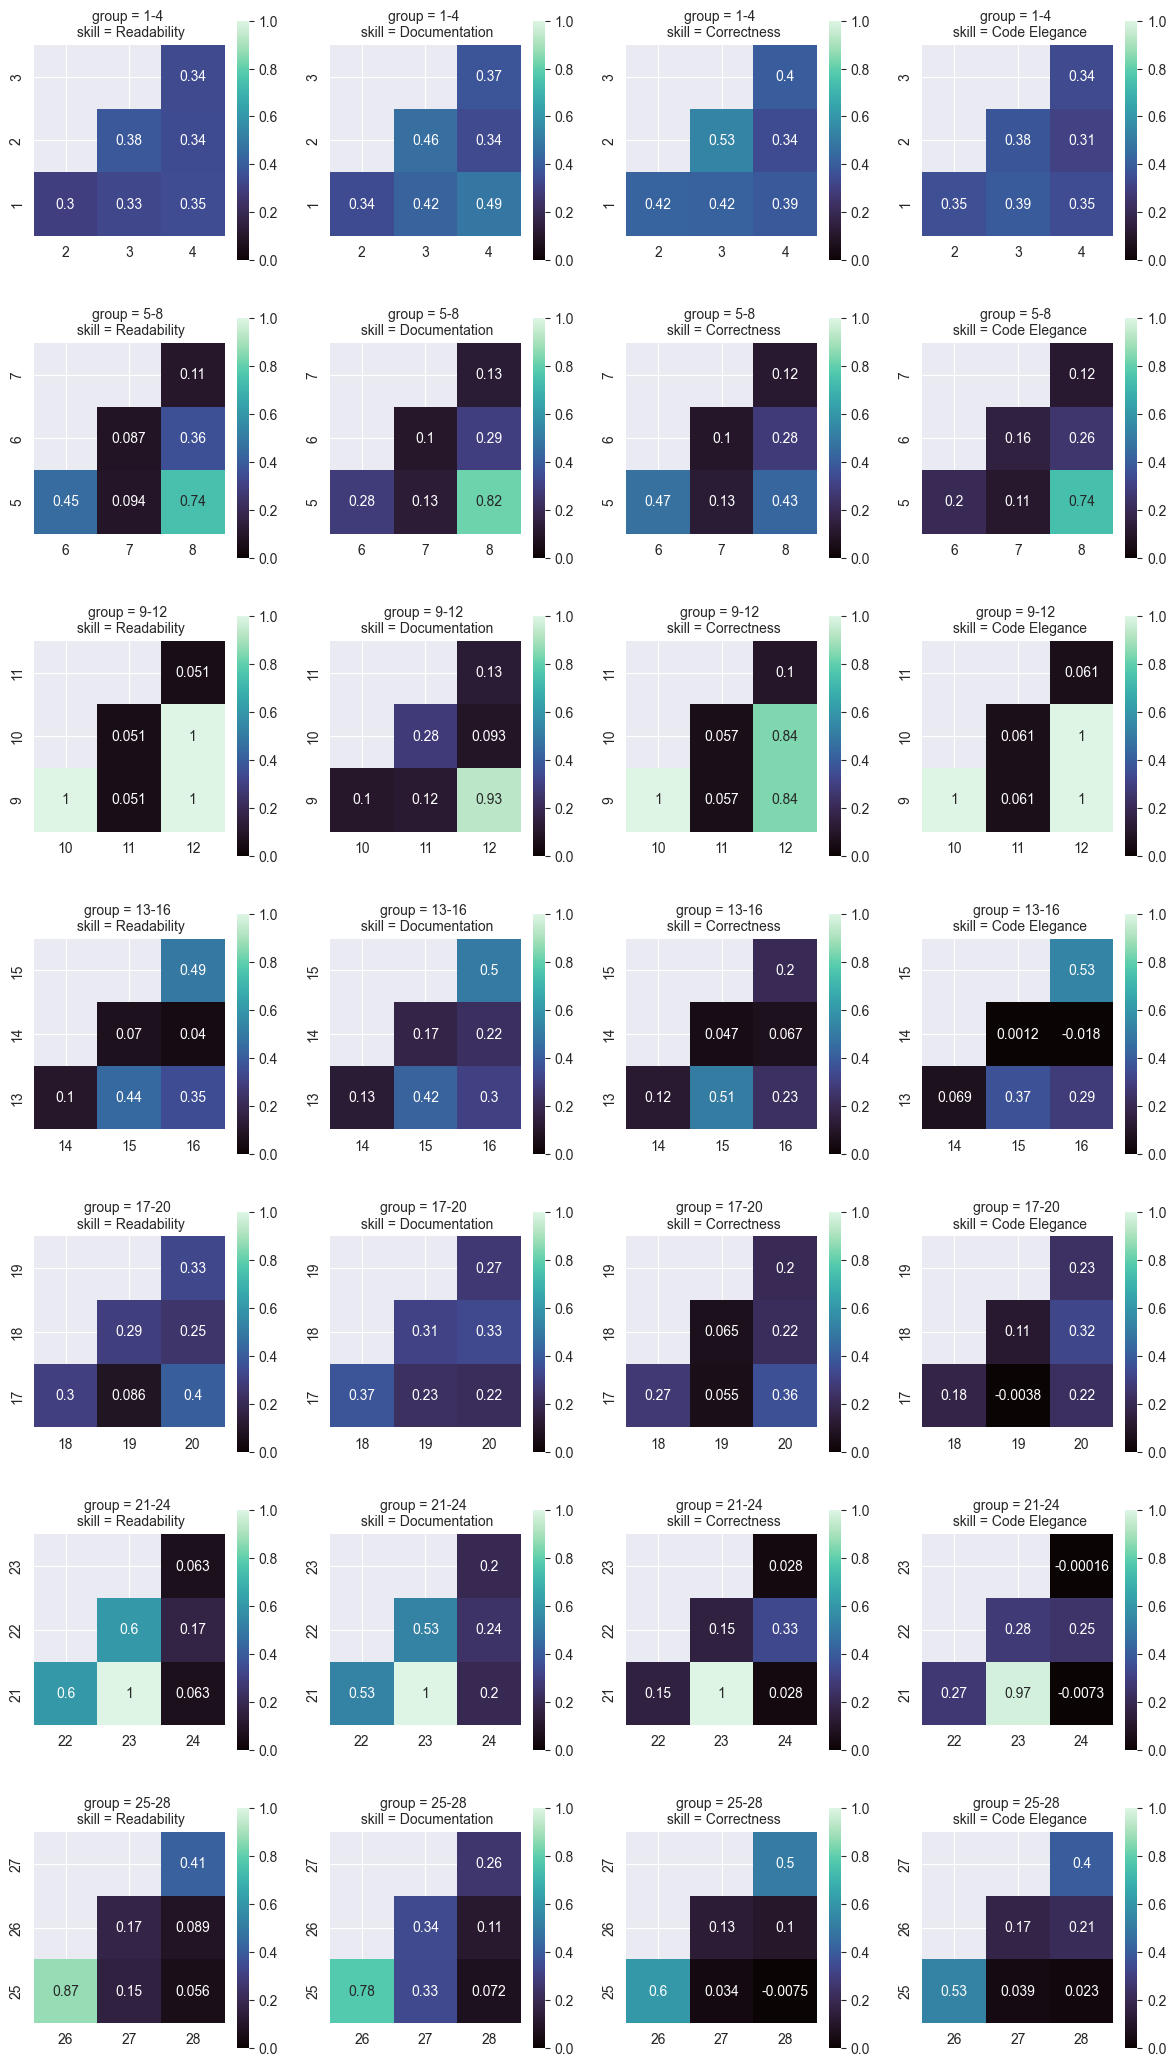

In [176]:
skills = inter_rater_sim_df['skill'].unique()
groups = inter_rater_sim_df['group'].unique()
g = sns.FacetGrid(inter_rater_sim_df, row='group', col='skill', 
                  col_order=skills, row_order=groups, sharey=False, sharex=False)
g.set_titles('{row_var} = {row_name} \n {col_var} = {col_name}')

for col_idx, group in enumerate(groups):
    for row_idx, skill in enumerate(skills):
        print(group, skill)
        a = sns.heatmap(ax=g.axes[col_idx, row_idx], data=generate_heatmap_data(skill=skill, group=group), square=True, cmap=sns.color_palette("mako", as_cmap=True), annot=True, vmin=0, vmax=1)
        a.set(xlabel='', ylabel='')
        a.invert_yaxis()
        
        
g.savefig('plots/inter_rater_sim_heatmap.pdf', bbox_inches='tight')